In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn as skl
import sklearn.model_selection as skl_ms
import seaborn as sns
import cv2
from PIL import Image
import tensorflow_addons as tfa

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tfk = tf.keras
tfkl = tf.keras.layers

In [5]:
dataframe = pd.read_csv('/kaggle/input/quality-annotated-dataframe/quality_annotated_dataframe.csv')

'''
dataframe = pd.read_csv("/kaggle/input/dataframe-quality-laplace-pre/dataframe_quality_laplace_pre.csv")
df_filtered = dataframe[dataframe['laplacian_pre']< 0.02237]
dataframe_path =df_filtered.rename(columns = {'file':'path'})

print("LEN OF ACTUAL DF:", len(dataframe))
print("LEN OF FILTERED DF:", len(dataframe_path))



'''


'\ndataframe = pd.read_csv("/kaggle/input/dataframe-quality-laplace-pre/dataframe_quality_laplace_pre.csv")\ndf_filtered = dataframe[dataframe[\'laplacian_pre\']< 0.02237]\ndataframe_path =df_filtered.rename(columns = {\'file\':\'path\'})\n\nprint("LEN OF ACTUAL DF:", len(dataframe))\nprint("LEN OF FILTERED DF:", len(dataframe_path))\n\n\n\n'

In [6]:

dataframe_quality = dataframe[dataframe['quality'] == 0]

filenames = dataframe_quality['file'].to_numpy()
to_remove = np.zeros(filenames.shape[0])

num_duplicates = 0

# Let's remove duplicates
for index in range(filenames.shape[0]):
    # Ignore the last element
    if index == filenames.shape[0] - 1:
        break
    
    filename = filenames[index]
    next_filename = filenames[index + 1]
    
    # Remove extension
    filename = filename.replace('.png', '')
    filename = filename.replace('.jpeg', '')
    next_filename = next_filename.replace('.png', '')
    next_filename = next_filename.replace('.jpeg', '')
    
    # If consecutive filenames refer to the same patient
    if filename[:-2] == next_filename[:-2]:
        to_remove[index + 1] = 1
        num_duplicates = num_duplicates + 1
        index = index + 1
        
dataframe_quality = dataframe_quality[to_remove == 0]
        
print('Removed %d duplicates' % num_duplicates)

dataframe_path = dataframe_quality.copy()
dataframe_path['path'] = '/kaggle/input/training-dataset/train/' + dataframe_path['label'] + '/' + dataframe_path['file']


Removed 1293 duplicates


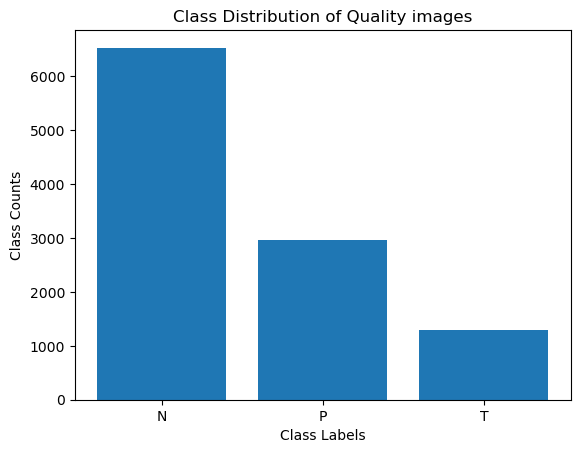

In [7]:
labels = dataframe_path['label']

# Create a bar plot
plt.bar(np.unique(labels), [np.sum(labels == l) for l in np.unique(labels)])

# Add labels and title to the plot
plt.xlabel('Class Labels')
plt.ylabel('Class Counts')
plt.title('Class Distribution of Quality images')

# Display the plot
plt.show()

In [8]:
seed = 3913326
train_path_based, test_path_based = train_test_split(dataframe_path,random_state = seed, test_size=0.2, shuffle=True)
train_path_based, validation_path_based = train_test_split(train_path_based, random_state=seed, test_size=0.1, shuffle=True)

In [9]:
def preprocessing(image):
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = np.uint8(image)

    # Check if background is Standard Radiological Format compliant, otherwise invert colors
    # (the check is performed on the median color along the spine)
    buffer = image / np.max(image)

    median_spine = np.median(buffer[:, buffer.shape[1] // 2])

    if median_spine < 0.5:
        image = cv2.bitwise_not(image)

    # Mist reduction and gamma transformation
    img_equalized = cv2.equalizeHist(image)
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                    for i in np.arange(0, 256)]).astype('uint8')
    img_gamma = cv2.LUT(img_equalized, table)

    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_gamma)

    # Apply Gaussian Smoothing
    gaussian_img = cv2.GaussianBlur(clahe_img, (5,5), 0)
    gaussian_img = gaussian_img.reshape((512,512,1))
    
    return gaussian_img

In [10]:
root_dir = '/kaggle/input/training-dataset/train/'
#root_dir = '/kaggle/input/dataframe-quality-laplace-pre/dataframe_quality_laplace_pre.csv'


train_datagen = ImageDataGenerator(preprocessing_function=preprocessing)
# Use flow_from_dataframe method to read images from directory based on dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    data_format="channels_last",
    color_mode='grayscale',
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)


validation_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

# Use flow_from_dataframe method to read images from directory based on dataframe
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    shuffle = False,
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    data_format="channels_last",
    color_mode='grayscale',
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)


test_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

# Use flow_from_dataframe method to read images from directory based on dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    shuffle = False,
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    data_format="channels_last",
    color_mode='grayscale',
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)

Found 7769 validated image filenames belonging to 3 classes.
Found 864 validated image filenames belonging to 3 classes.
Found 2159 validated image filenames belonging to 3 classes.


In [11]:
pretrained_model = tfk.applications.MobileNet(
    input_shape=(512,512,3),
    include_top=False,
    weights="imagenet")

17225924/17225924 [==============================] - 0s 0us/step


In [12]:
for i, layer in enumerate(pretrained_model.layers):
    print(f'{i} - {layer.name}')

0 - input_1
1 - conv1
2 - conv1_bn
3 - conv1_relu
4 - conv_dw_1
5 - conv_dw_1_bn
6 - conv_dw_1_relu
7 - conv_pw_1
8 - conv_pw_1_bn
9 - conv_pw_1_relu
10 - conv_pad_2
11 - conv_dw_2
12 - conv_dw_2_bn
13 - conv_dw_2_relu
14 - conv_pw_2
15 - conv_pw_2_bn
16 - conv_pw_2_relu
17 - conv_dw_3
18 - conv_dw_3_bn
19 - conv_dw_3_relu
20 - conv_pw_3
21 - conv_pw_3_bn
22 - conv_pw_3_relu
23 - conv_pad_4
24 - conv_dw_4
25 - conv_dw_4_bn
26 - conv_dw_4_relu
27 - conv_pw_4
28 - conv_pw_4_bn
29 - conv_pw_4_relu
30 - conv_dw_5
31 - conv_dw_5_bn
32 - conv_dw_5_relu
33 - conv_pw_5
34 - conv_pw_5_bn
35 - conv_pw_5_relu
36 - conv_pad_6
37 - conv_dw_6
38 - conv_dw_6_bn
39 - conv_dw_6_relu
40 - conv_pw_6
41 - conv_pw_6_bn
42 - conv_pw_6_relu
43 - conv_dw_7
44 - conv_dw_7_bn
45 - conv_dw_7_relu
46 - conv_pw_7
47 - conv_pw_7_bn
48 - conv_pw_7_relu
49 - conv_dw_8
50 - conv_dw_8_bn
51 - conv_dw_8_relu
52 - conv_pw_8
53 - conv_pw_8_bn
54 - conv_pw_8_relu
55 - conv_dw_9
56 - conv_dw_9_bn
57 - conv_dw_9_relu
58 - co

In [13]:
# Define the input shape
input_shape = (512, 512, 3)

# Define the number of classes
num_classes = 3

# Freeze the layers in the base model
pretrained_model.trainable = True

freeze_layer_limit = 367

# Freeze first layers
for i, layer in enumerate(pretrained_model.layers[:freeze_layer_limit]):
    layer.trainable=False

# Data Augmentation layers
inputs = keras.layers.Input((512,512,1))
x = keras.layers.RandomBrightness(0.11)(inputs)
x = keras.layers.RandomZoom(0.21, fill_mode='constant', interpolation='bilinear',fill_value=0.0)(x)
x = keras.layers.RandomContrast(0.105)(x)
x = keras.layers.RandomRotation(0.5, fill_mode='constant', interpolation='bilinear',fill_value=0.0)(x)
x = keras.layers.RandomTranslation(0.12, 0.15, fill_mode='constant', interpolation='bilinear',fill_value=0.0)(x)
x = keras.layers.GaussianNoise(stddev=1.0)(x)
x = keras.layers.Reshape((512,512,1))(x)
x = keras.layers.concatenate([x for i in range(3)],axis=-1)
x = keras.layers.Lambda(function=keras.applications.densenet.preprocess_input, output_shape=(512,512,3))(x)

x = pretrained_model(x)
    
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Dense(units = 256, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [14]:
# Compile the model
model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer=tfa.optimizers.Yogi(1e-4), metrics='accuracy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 random_brightness (RandomBrigh  (None, 512, 512, 1)  0          ['input_2[0][0]']                
 tness)                                                                                           
                                                                                                  
 random_zoom (RandomZoom)       (None, 512, 512, 1)  0           ['random_brightness[0][0]']      
                                                                                              

In [15]:
#MobileNet
history_model = model.fit(
    x = train_generator,
    batch_size = 64,
    epochs = 30,
    validation_data = validation_generator,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, min_lr=1e-6)]
).history

Epoch 1/30
122/122 [==============================] - 315s 2s/step - loss: 0.2211 - accuracy: 0.5635 - val_loss: 0.1431 - val_accuracy: 0.7211 - lr: 1.0000e-04
Epoch 2/30
122/122 [==============================] - 285s 2s/step - loss: 0.1578 - accuracy: 0.6650 - val_loss: 0.1075 - val_accuracy: 0.7963 - lr: 1.0000e-04
Epoch 3/30
122/122 [==============================] - 286s 2s/step - loss: 0.1377 - accuracy: 0.7133 - val_loss: 0.1116 - val_accuracy: 0.8009 - lr: 1.0000e-04
Epoch 4/30
122/122 [==============================] - 279s 2s/step - loss: 0.1295 - accuracy: 0.7248 - val_loss: 0.0919 - val_accuracy: 0.8380 - lr: 1.0000e-04
Epoch 5/30
122/122 [==============================] - 283s 2s/step - loss: 0.1232 - accuracy: 0.7523 - val_loss: 0.0836 - val_accuracy: 0.8391 - lr: 1.0000e-04
Epoch 6/30
122/122 [==============================] - 300s 2s/step - loss: 0.1159 - accuracy: 0.7720 - val_loss: 0.0823 - val_accuracy: 0.8519 - lr: 1.0000e-04
Epoch 7/30
122/122 [====================

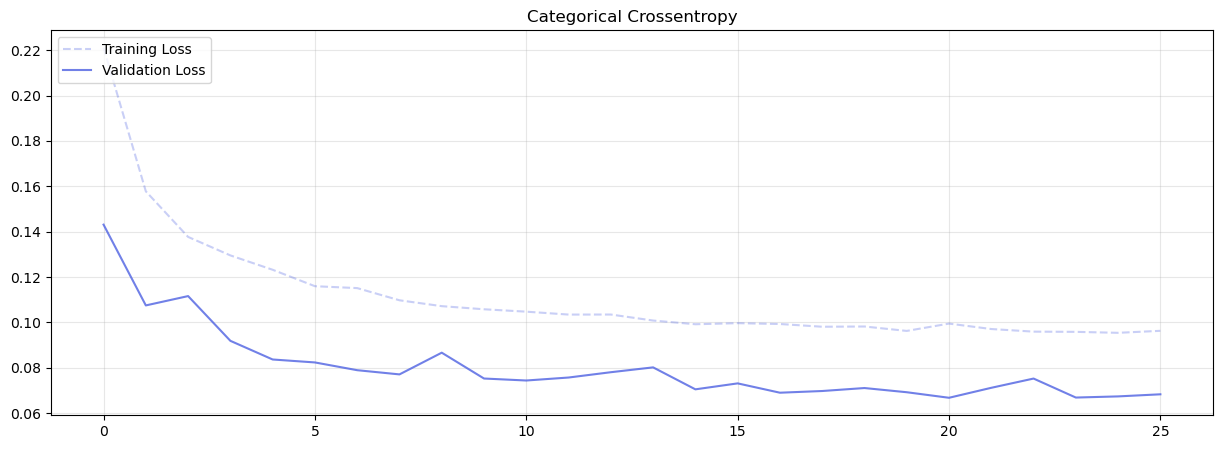

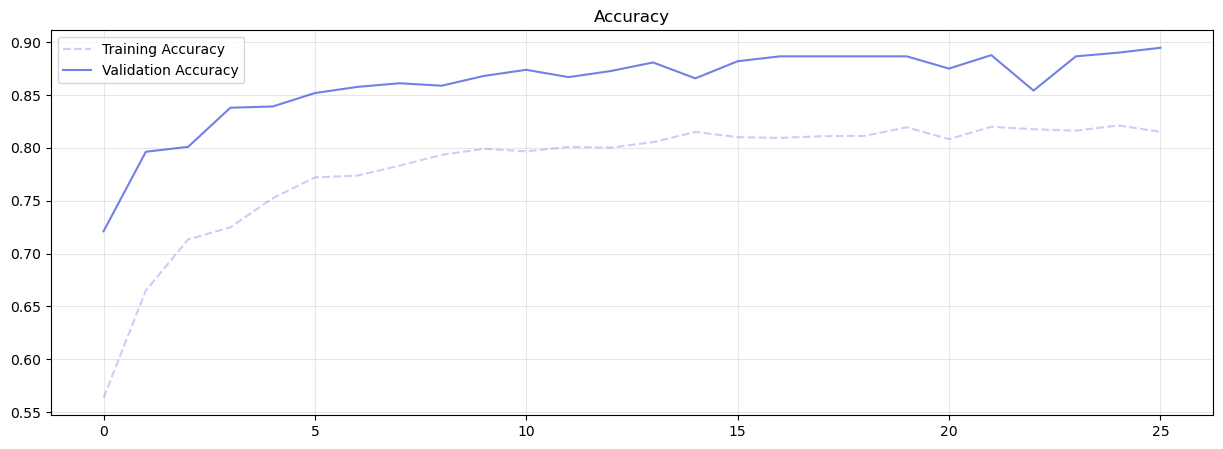

In [18]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history_model['loss'], label='Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_model['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history_model['accuracy'], label = 'Training Accuracy', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_model['val_accuracy'], label='Validation Accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [22]:
# Predict the test set with the CNN1
predictions = model.predict(test_generator)
label_names = {
    0: "N",
    1: "P",
    2: "T"
}
prediction_numerical = np.argmax(predictions, axis=-1)
label_classes = label_names.values()
converted_test_labels = np.zeros(test_path_based["label"].shape)
converted_test_labels[test_path_based["label"] == 'N'] = 0
converted_test_labels[test_path_based["label"] == 'P'] = 1
converted_test_labels[test_path_based["label"] == 'T'] = 2 

34/34 [==============================] - 37s 1s/step


Accuracy: 0.8805
Precision: 0.875
Recall: 0.7832
F1: 0.8115


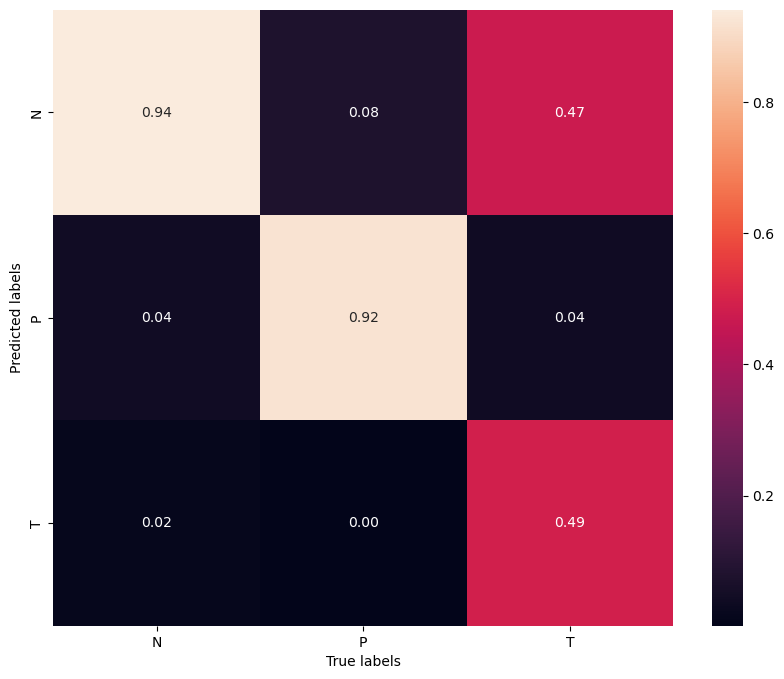

In [23]:
# Compute the confusion matrix-Mobile
cm = confusion_matrix(converted_test_labels, np.argmax(predictions, axis=-1))
cm_rel = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Compute the classification metrics
accuracy = accuracy_score(converted_test_labels, np.argmax(predictions, axis=-1))
precision = precision_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_rel.T, xticklabels=label_classes, yticklabels=label_classes, annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [24]:
from sklearn.metrics import classification_report
# generate the classification report
print(classification_report(converted_test_labels, prediction_numerical, target_names=['Normal', 'Pneumonia', 'Tuberculosis']))

              precision    recall  f1-score   support

      Normal       0.88      0.94      0.91      1319
   Pneumonia       0.89      0.92      0.90       577
Tuberculosis       0.86      0.49      0.62       263

    accuracy                           0.88      2159
   macro avg       0.88      0.78      0.81      2159
weighted avg       0.88      0.88      0.87      2159



In [19]:
print(tf.__version__)

2.11.0


In [ ]:
#save_path = '/kaggle/working/'

# Save the model
model.save('MobileNet-MedModel-withAug')

print("Model saved successfully.")

Model saved successfully.


In [ ]:
!zip -r MobileNet-MedModel-withAug.zip MobileNet-MedModel-withAug -r 

  adding: MobileNet-MedModel-withAug/ (stored 0%)
  adding: MobileNet-MedModel-withAug/keras_metadata.pb (deflated 95%)
  adding: MobileNet-MedModel-withAug/variables/ (stored 0%)
  adding: MobileNet-MedModel-withAug/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: MobileNet-MedModel-withAug/variables/variables.index (deflated 75%)
  adding: MobileNet-MedModel-withAug/saved_model.pb (deflated 91%)
  adding: MobileNet-MedModel-withAug/fingerprint.pb (stored 0%)
  adding: MobileNet-MedModel-withAug/assets/ (stored 0%)


Apparently, there is a bug with tensorflow versions >= 2.10.0 Efficientnet networks cannot be serialized. I need to retrain the model with tensorflow 2.9.0 to be able to export it.